In [1]:
from pyscal.crystal_structures import Structure
from pyscal_rdf.graph import StructureGraph
from pyscal_rdf.queries import Query

Update hedgedoc [here](https://iffmd.fz-juelich.de/BRIkKGLlQduS8dA0sXKoZw)

## Creating structure and add to graph

In [2]:
struct = Structure()

In [3]:
sys = struct.lattice.l12(element=['Al', 'Ni'], 
                         lattice_constant=3.57)

['Al', 'Ni']


Create a new graph and add data

In [4]:
g = StructureGraph()
g.add_structure_to_graph(sys, names=True)

Create a new structure and add it

In [5]:
sys = struct.element.Fe()

Fe


Add this too to the graph

In [6]:
g.add_structure_to_graph(sys)

Write graph

In [7]:
query = """
PREFIX cmso: <https://purls.helmholtz-metadaten.de/cmso/>
SELECT DISTINCT ?sample
WHERE {
    ?bravaislattice cmso:hasLatticeSystem ?latticesystem .
    ?unitcell cmso:hasLattice ?bravaislattice .
    ?structure cmso:hasUnitCell ?unitcell .
    ?material cmso:hasStructure ?structure .
    ?sample cmso:hasMaterial ?material .
FILTER (?latticesystem="fcc"^^xsd:string)
}"""

In [8]:
res = g.graph.query(query)

In [9]:
for r in res:
    print(r)

(rdflib.term.BNode('01_Sample'),)


In [50]:
g.write("outx.xml", format='pretty-xml')

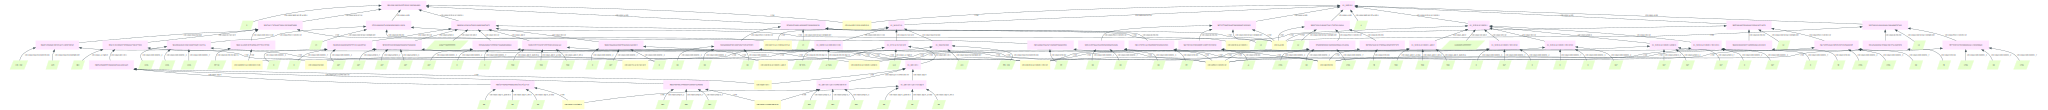

In [24]:
g.visualise()

In [9]:
g.sysdict

{'ChemicalCompositionElement': ['Fe'],
 'ChemicalCompositionRatio': [1.0],
 'CellVolume': 638.2773809999999,
 'NumberOfAtoms': 2,
 'SimulationCellLengthX': 2.87,
 'SimulationCellLengthY': 2.87,
 'SimulationCellLengthZ': 2.87,
 'SimulationCellVectorA': [2.87, 0, 0],
 'SimulationCellVectorB': [0, 2.87, 0],
 'SimulationCellVectorC': [0, 0, 2.87],
 'SimulationCellAngleAlpha': 90.0,
 'SimulationCellAngleBeta': 90.0,
 'SimulationCellAngleGamma': 90.0,
 'Element': ['Fe', 'Fe'],
 'Coordination': [14, 14],
 'Positions': [[0.0, 0.0, 0.0], [1.435, 1.435, 1.435]],
 'LatticeParameter': 2.87,
 'SpaceGroupSymbol': 'Im-3m',
 'SpaceGroupNumber': 229,
 'CrystalStructureName': 'bcc',
 'BravaisLattice': 'bcc',
 'BasisPositions': [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]],
 'BasisOccupancy': ['Fe', 'Fe'],
 'LatticeVectors': [[1.0, 0, 0], [0, 1.0, 0], [0, 0, 1.0]]}

- Add bravaisLattice

## Querying data

We can use some prepared queries

In [28]:
q = Query()

Queries can be done using SPARQL backend or RDFLIB

The below query gets samples with given altname

In [29]:
samples = q.sparql.sample_by_altname(g, 'bcc')

In [30]:
samples = q.python.sample_by_altname(g, 'bcc')

How many samples were found?

In [31]:
len(samples)

1

Write out the given sample to a format, first lammps

In [32]:
g.to_file(samples[0], "sample.dump")

Convert to ase

In [33]:
aseobj = g.to_file(samples[0], format="ase")

In [34]:
aseobj

Atoms(symbols='Fe2', pbc=True, cell=[2.87, 2.87, 2.87])

In [18]:
from ase.io import write

In [19]:
write('POSCAR', aseobj)

In [21]:
g.to_file(samples[0], 'POSCAR', format="poscar")

/home/menon/miniconda3/envs/pyscal-rdf/lib/python3.9/site-packages/pyscal/formats/vasp.py:57: UserWarning: Using legacy poscar writer, to use ASE backend specify species
  warnings.warn("Using legacy poscar writer, to use ASE backend specify species")


TypeError: 'int' object is not iterable

We use `BNode` for the moment, is it really the best option? Please check

- Control decimal points
- Add references
- Plot: add fig size
- Plot: add font size
- Plot: add duplicate labels
- Dont hardcode lattice angles

`DCTERMS.http://purl.org/dc/terms/bibliographicCitation`